## VAE analysis of two lung cancer sets

Here we training a VAE of two different datasets within the TCGA. We will first merge the two datasets and subsequently try to separate the samples based on their latent variables. This is made in analogue with the notebook on PCA.

First we retrieve our two TCGA lungcancer data from cbioportal.org. One of the sets are from [Lung Adenocarcinomas](https://en.wikipedia.org/wiki/Adenocarcinoma_of_the_lung) and the other is from [Lung Squamous Cell Carcinomas](https://en.wikipedia.org/wiki/Squamous-cell_carcinoma_of_the_lung). We first load our dataset.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append("..") # Read loacal modules for tcga access and qvalue calculations
import tcga_read as tcga

luad = tcga.get_expression_data("../../data/luad.tsv.gz", 'http://download.cbioportal.org/luad_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
lusc = tcga.get_expression_data("../../data/lusc.tsv.gz", 'http://download.cbioportal.org/lusc_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")

We now merge the datasets, and see too that we only include transcripts that are measured in all the carcinomas with an count larger than 0. Further we scale the measurements so that every gene expression value is scaled between 0 and 1, using sk-learns [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined = pd.concat([lusc, luad], axis=1, sort=False)
combined.dropna(axis=0, how='any', inplace=True)
combined = combined.loc[~(combined<=0.0).any(axis=1)]
X=scaler.fit_transform(np.log2(combined).T).T
combined = pd.DataFrame(data=X,index=combined.index,columns=combined.columns)

We are setting up an istance of a machine learning framework, [PyTorch](https://en.wikipedia.org/wiki/PyTorch). It will help us fitting the needed neural network.

In [72]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.utils.data
from torch.nn import functional as F
from torchvision import datasets, transforms


import numpy as np

from tqdm import tqdm
from torchvision.utils import make_grid

## We use a GPU and hence need cuda, https://en.wikipedia.org/wiki/CUDA
no_cuda = False

## Some arbitrarly selected training parameters
batch_size, lr, epochs, log_interval = 128, 1e-3, 1000, 100

## Some parameters governing the architecture.
hidden_dim, latent_dim = 64, 2

use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(4711)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


When training a network on a GPU, we need a special data öoader that can transfer the data to the GPU.

In [73]:
class ExpressionDataset(Dataset):
    def __init__(self, datapoints, labels):
        self.x_dim = datapoints.shape[0]
        self.datapoints = torch.tensor(datapoints.to_numpy().T, dtype=torch.float32)
        print(self.datapoints)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.datapoints[idx],self.labels[idx]

train_dataset = ExpressionDataset(combined,([1.0 for _ in lusc.columns]+[ 0.0 for _ in luad.columns]))
#train_dataset = ExpressionDataset(combined,(["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns]))
#test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
x_dim  = train_dataset.x_dim

tensor([[0.7966, 0.7539, 0.5268,  ..., 0.4000, 0.1724, 0.3890],
        [0.4545, 0.6363, 0.5624,  ..., 0.6170, 0.5138, 0.4735],
        [0.0000, 0.7093, 0.6046,  ..., 0.0454, 0.4523, 0.3972],
        ...,
        [0.6600, 0.5818, 0.4055,  ..., 0.4112, 0.7615, 0.2131],
        [0.6401, 0.1870, 0.6983,  ..., 0.6335, 0.7845, 0.2495],
        [0.5654, 0.6486, 0.8129,  ..., 0.6818, 0.7986, 0.2701]])


Now we design the VAE. We use an architecure where 13046 features are first throtteled down to 64 features (fc1) then to 2 features, which we predict both mean and variance for (fc21 and fc22).   

We reparametrize those 2 variables, and then expand them to 64 (fc3) and 13046 (fc4) features.
![](img/nn.svg)


In [74]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, x_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h3))
        return out

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Next, we next select a gradient descent optimizer, [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam), and select a fuction to optimize, the loss_function, and we define a train and test procedure to use.

In [75]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(f"BCE={BCE}, KLD={KLD}")
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    if epoch % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
#        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    if epoch % log_interval == 0:
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


Now we are set to run the procedure for 1000 epochs.

In [76]:
for epoch in range(1, epochs + 1):
    train(epoch)
test(epoch)

Train Epoch: 100 [0/994 (0%)]	Loss: 8676.635742
Train Epoch: 100 [128/994 (12%)]	Loss: 8669.390625
Train Epoch: 100 [256/994 (25%)]	Loss: 8696.019531
Train Epoch: 100 [384/994 (38%)]	Loss: 8682.718750
Train Epoch: 100 [512/994 (50%)]	Loss: 8680.566406
Train Epoch: 100 [640/994 (62%)]	Loss: 8679.761719
Train Epoch: 100 [768/994 (75%)]	Loss: 8684.580078
Train Epoch: 100 [686/994 (88%)]	Loss: 8685.045281
====> Epoch: 100 Average loss: 8681.7430
Train Epoch: 200 [0/994 (0%)]	Loss: 8648.874023
Train Epoch: 200 [128/994 (12%)]	Loss: 8673.542969
Train Epoch: 200 [256/994 (25%)]	Loss: 8666.938477
Train Epoch: 200 [384/994 (38%)]	Loss: 8671.108398
Train Epoch: 200 [512/994 (50%)]	Loss: 8673.667969
Train Epoch: 200 [640/994 (62%)]	Loss: 8688.653320
Train Epoch: 200 [768/994 (75%)]	Loss: 8674.257812
Train Epoch: 200 [686/994 (88%)]	Loss: 8692.939413
====> Epoch: 200 Average loss: 8673.1686
Train Epoch: 300 [0/994 (0%)]	Loss: 8669.484375
Train Epoch: 300 [128/994 (12%)]	Loss: 8680.239258
Train Epo

We have now trained our VAE. We can first evaluate it for the datapoints we trained it on, and get their embeddings in a vector, $y$.

In [77]:
model.eval()

x_batch, z_batch = [], []
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        
        x_hat_, mean_, log_var = model(x)
        x_batch.append(x_hat_.cpu().detach().numpy())
        z_batch.append(mean_.cpu().detach().numpy())

x_hat = np.concatenate(x_batch, axis=0)
z = np.concatenate(z_batch, axis=0)

100%|██████████| 8/8 [00:00<00:00, 89.34it/s]


We can now use the embeddings to describe our data. Much like for the PCA we can use the embeddings to give a dimentionallity reduced description of each cancer's expression profile. 

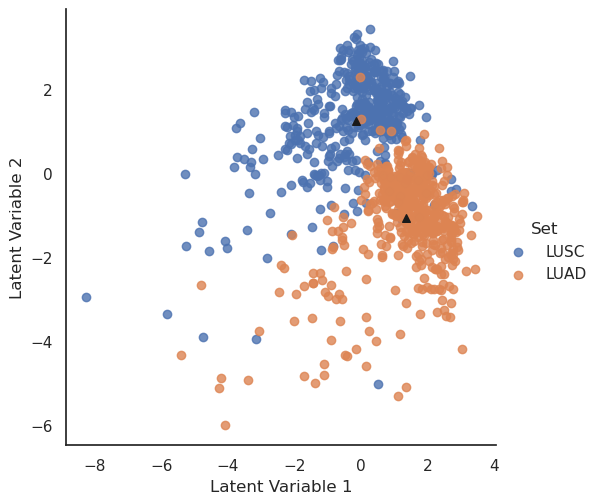

In [78]:
transformed_patients = pd.DataFrame(data=z,columns=["Latent Variable 1","Latent Variable 2"],index=list(lusc.columns) + list(luad.columns))
transformed_patients["Set"]= (["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns])

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
#sns.set_context("talk")

sns.lmplot(x="Latent Variable 1",y="Latent Variable 2", hue='Set', data=transformed_patients, fit_reg=False)
means={}
for name,set_ in transformed_patients.groupby("Set"):
    means[name] = set_.mean(numeric_only=True).to_numpy()
    plt.scatter(means[name][0],means[name][1], marker='^',s=30,c='k')

Here we see a quite good, but not perfect separation of the patients based on two latent variables.

Furter, we can use the network to generate "typical" expression profiles. We have marked the means of each sample with black triangles. We will now generate two expression profiles based on these means and use them as representation of each cancer type. 

In [79]:
z_fix = torch.tensor(np.concatenate(([means["LUSC"]],[means["LUAD"]]), axis=0))

z_fix = z_fix.to(device)
x_fix = model.decode(z_fix).cpu().detach().numpy()
predicted = pd.DataFrame(data=x_fix.T, index=combined.index, columns=["LUSC", "LUAD"])

We can now identify the genes most differential between the typical LUSC and LUAD sample. 

In [80]:
predicted["diff"] = predicted["LUSC"] - predicted["LUAD"]
# predicted.sort_values(by='diff', ascending=False, inplace = True)

The genes pointing in a negative direction for the two components are:

In [81]:
predicted["diff"].idxmin(axis=0)

'GNA14'

In [82]:
predicted["diff"].idxmax(axis=0)

'S1PR5'

Here these two genes seems to be the largest differentiators beteen the genes in LUSC and LUAD. We can also note that as before, the Gene KRT17 seems quite different between the cancer types:

In [83]:
predicted.loc["KRT17"]

LUSC    0.773740
LUAD    0.484323
diff    0.289417
Name: KRT17, dtype: float32